In [1]:
using Distributed, PGFPlots
addprocs(7)
STYLE = (width="10cm", height="10cm")

(width = "10cm", height = "10cm")

In [2]:
@everywhere begin
    using Test, AdvancedHMC, LinearAlgebra, DataFrames, MCMCChains
    using AdvancedHMC.Adaptation: NoAdaptation
    using Parameters: reconstruct
    using Statistics: mean, var, cov
    
    # Target distributions
    using Distributions: logpdf, MvNormal, InverseGamma, Normal
    using DiffResults: GradientResult, value, gradient
    using ForwardDiff: gradient!

    target1 = let D=5
        mu, sig = zeros(D), ones(D)
        ℓπ(θ) = logpdf(MvNormal(mu, sig), θ)

        function ∂ℓπ∂θ(θ)
            res = GradientResult(θ)
            gradient!(res, ℓπ, θ)
            return (value(res), gradient(res))
        end
    
        (name="$(D)D Gaussian", D=D, ℓπ=ℓπ, ∂ℓπ∂θ=∂ℓπ∂θ)
    end

    target2 = let D=2
        function ℓπ(θ)
            s = exp(θ[1])
            m = θ[2]
            logprior = logpdf(InverseGamma(2, 3), s) + log(s) + logpdf(Normal(0, sqrt(s)), m) 
            loglikelihood = logpdf(Normal(m, sqrt(s)), 1.5) + logpdf(Normal(m, sqrt(s)), 2.0)
            return logprior + loglikelihood
        end

        function ∂ℓπ∂θ(θ)
            res = GradientResult(θ)
            gradient!(res, ℓπ, θ)
            return (value(res), gradient(res))
        end
        
        (name="Conjugate Gaussian", D=D, ℓπ=ℓπ, ∂ℓπ∂θ=∂ℓπ∂θ)
    end
end

┌ Info: Recompiling stale cache file /Users/kai/.julia/compiled/v1.2/AdvancedHMC/WaglY.ji for AdvancedHMC [0bf59076-c3b1-5ca4-86bd-e02cd72cde3d]
└ @ Base loading.jl:1240


In [3]:
target = target2

(name = "Conjugate Gaussian", D = 2, ℓπ = getfield(Main, Symbol("##8#ℓπ#5"))(), ∂ℓπ∂θ = getfield(Main, Symbol("##9#∂ℓπ∂θ#6")){getfield(Main, Symbol("##8#ℓπ#5"))}(getfield(Main, Symbol("##8#ℓπ#5"))()))

In [4]:
@everywhere function compute_metrics(samples, stats)
    val = hcat(samples...)'
    val = reshape(val, size(val)..., 1)
    chain = Chains(val)
    df = MCMCChains.describe(chain)[1].df
    ess = mean(df[!,:ess])
    mcse = mean(df[!,:mcse])
    n_steps_total = sum(map(t -> t.n_steps, stats))
    return (ess_ps=ess / n_steps_total, mcse=mcse)
end

function report!(container::AbstractArray, samples, stats; args=NamedTuple())
    ess_ps, mcse = compute_metrics(samples, stats)
    push!(container, (args..., ess_ps=ess_ps, mcse=mcse))
end

@everywhere function report!(container::RemoteChannel, samples, stats; args=NamedTuple())
    ess_ps, mcse = compute_metrics(samples, stats)
    put!(container, (args..., ess_ps=ess_ps, mcse=mcse))
end

n_samples = 12_000
n_adapts = 2_000
let n_runs=5
    results = RemoteChannel(() -> Channel(n_runs))
    @time @sync @distributed for _ in 1:n_runs
        let θ_init=rand(target.D),
            metric=DenseEuclideanMetric(target.D),
            h=Hamiltonian(metric, target.ℓπ, target.∂ℓπ∂θ),
            ϵ=find_good_eps(h, θ_init), 
            lf=Leapfrog(ϵ), 
            adaptor=StanHMCAdaptor(
                n_adapts,
                Preconditioner(metric),
                NesterovDualAveraging(0.8, lf.ϵ),
            )
            samples, stats = sample(h, NUTS{MultinomialTS,GeneralisedNoUTurn}(lf), θ_init, n_samples, adaptor, n_adapts; verbose=false, progress=false, drop_warmup=false)
            report!(results, samples[n_adapts+1:end], stats[n_adapts+1:end])
        end
    end
    close(results)
    # Fetch results
    results = [take!(results) for _ in 1:n_runs]
    # Show results
    ess_ps_list = map(t -> t.ess_ps, results) |> collect
    mcse_list = map(t -> t.mcse, results) |> collect
    @info "NUTS ($n_runs runs)" mean(ess_ps_list) var(ess_ps_list) mean(mcse_list) var(mcse_list)
end

199.402882 seconds (2.71 M allocations: 138.230 MiB, 0.02% gc time)


┌ Info: NUTS (5 runs)
│   mean(ess_ps_list) = 0.08520472302543868
│   var(ess_ps_list) = 9.525873168321944e-5
│   mean(mcse_list) = 0.011169865407636575
│   var(mcse_list) = 1.0601266476484831e-6
└ @ Main In[4]:47


In [5]:
arg_list = []

for ϵ in 0.1:0.2:1.6,
    n_steps in [1, 2, 4, 8],
    α in 0.1:0.1:1.0
    push!(arg_list, (name=target.name, ϵ=ϵ, n_steps=n_steps, α=α))
end

metric = UnitEuclideanMetric(target.D)
h = Hamiltonian(metric, target.ℓπ, target.∂ℓπ∂θ)
adaptor = NoAdaptation()

n_exps = length(arg_list)
println("Generated $n_exps experiment settings.")

Generated 320 experiment settings.


In [6]:
results = RemoteChannel(() -> Channel(n_exps))

println("Running $n_exps experiments ...")
@time @sync @distributed for args in arg_list
    samples, stats = sample(h,  HMC{MultinomialTS}(Leapfrog(args.ϵ), args.n_steps) , rand(target.D), n_samples, adaptor, n_adapts; α=args.α, verbose=false, progress=false, drop_warmup=false)
    # Report results
    report!(results, samples[n_adapts+1:end], stats[n_adapts+1:end]; args=args)
end

close(results)

results = [take!(results) for _ in 1:n_exps]

Running 320 experiments ...
154.127179 seconds (330.49 k allocations: 15.573 MiB, 0.00% gc time)


320-element Array{NamedTuple{(:name, :ϵ, :n_steps, :α, :ess_ps, :mcse),Tuple{String,Float64,Int64,Float64,Float64,Float64}},1}:
 (name = "Conjugate Gaussian", ϵ = 0.7, n_steps = 2, α = 0.9, ess_ps = 0.17195044384484567, mcse = 0.012857047205870695) 
 (name = "Conjugate Gaussian", ϵ = 0.5, n_steps = 2, α = 0.3, ess_ps = 0.13174114634502126, mcse = 0.014822146859481269) 
 (name = "Conjugate Gaussian", ϵ = 0.9, n_steps = 4, α = 0.5, ess_ps = 0.041686353485636596, mcse = 0.018217073505219016)
 (name = "Conjugate Gaussian", ϵ = 0.7, n_steps = 2, α = 1.0, ess_ps = 0.18425453490783694, mcse = 0.012656104569732197) 
 (name = "Conjugate Gaussian", ϵ = 1.3, n_steps = 8, α = 0.6, ess_ps = 0.00346666803215684, mcse = 0.037002517899291626) 
 (name = "Conjugate Gaussian", ϵ = 1.1, n_steps = 8, α = 0.1, ess_ps = 0.005654301366362821, mcse = 0.032199714220448226)
 (name = "Conjugate Gaussian", ϵ = 0.9, n_steps = 4, α = 0.6, ess_ps = 0.04970115278977478, mcse = 0.016250815573263116) 
 (name = "Conjugat

In [7]:
df = DataFrame()
for r in results
    push!(df, map(x -> x isa Number && isnan(x) ? 0 : x, r))
end
println(df)

320×6 DataFrame
│ Row │ name               │ ϵ       │ n_steps │ α       │ ess_ps     │ mcse       │
│     │ String             │ Float64 │ Int64   │ Float64 │ Float64    │ Float64    │
├─────┼────────────────────┼─────────┼─────────┼─────────┼────────────┼────────────┤
│ 1   │ Conjugate Gaussian │ 0.7     │ 2       │ 0.9     │ 0.17195    │ 0.012857   │
│ 2   │ Conjugate Gaussian │ 0.5     │ 2       │ 0.3     │ 0.131741   │ 0.0148221  │
│ 3   │ Conjugate Gaussian │ 0.9     │ 4       │ 0.5     │ 0.0416864  │ 0.0182171  │
│ 4   │ Conjugate Gaussian │ 0.7     │ 2       │ 1.0     │ 0.184255   │ 0.0126561  │
│ 5   │ Conjugate Gaussian │ 1.3     │ 8       │ 0.6     │ 0.00346667 │ 0.0370025  │
│ 6   │ Conjugate Gaussian │ 1.1     │ 8       │ 0.1     │ 0.0056543  │ 0.0321997  │
│ 7   │ Conjugate Gaussian │ 0.9     │ 4       │ 0.6     │ 0.0497012  │ 0.0162508  │
│ 8   │ Conjugate Gaussian │ 1.3     │ 8       │ 0.7     │ 0.00358066 │ 0.0422501  │
│ 9   │ Conjugate Gaussian │ 1.1     │ 8       │ 

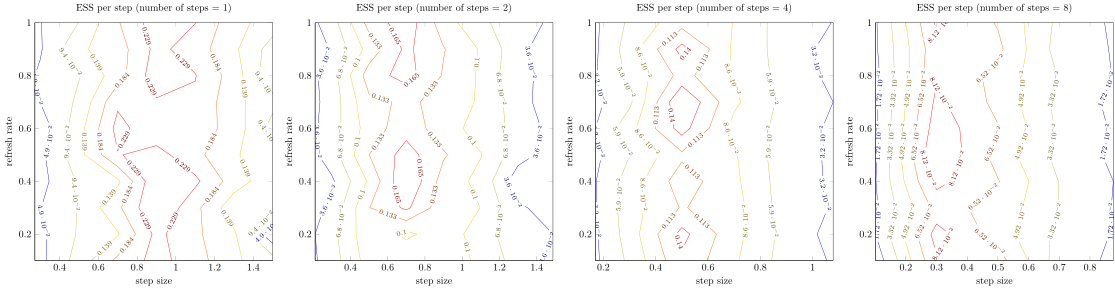

In [8]:
gp = GroupPlot(4, 1, groupStyle = "horizontal sep = 1.5cm, vertical sep = 2.0cm")

idx_sym = :n_steps
idx = (val=sort(unique(df[!, idx_sym])), name="number of steps")
for idx_val in idx.val
    let df=df[df[!,idx_sym] .== idx_val,:]
        x_sym = :ϵ
        x = (val=sort(unique(df[!, x_sym])), name="step size")
        y_sym = :α
        y = (val=sort(unique(df[!, y_sym])), name="refresh rate")
        z = Matrix{Float64}(undef, length(x.val), length(y.val))
        for (i, xi) in enumerate(x.val), 
            (j, yj) in enumerate(y.val)
            _df = df[df[!, x_sym] .≈ xi,:]
            z[i,j] = _df[_df[!, y_sym] .≈ yj,:].ess_ps[]
        end

        push!(gp, Axis(Plots.Contour(z, x.val, y.val); xlabel=x.name, ylabel=y.name, title="ESS per step ($(idx.name) = $idx_val)", STYLE...))
    end
end

gp

In [ ]:
# for (metricstr, metric) in Dict(
#         "Unit" => UnitEuclideanMetric(D),
# #         "Diag" => DiagEuclideanMetric(D),
# #         "Dense" => DenseEuclideanMetric(D),
#     )
#     h = Hamiltonian(metric, ℓπ, ∂ℓπ∂θ)
#     for (lfstr, lf) in Dict(
#             ("Leapfrog" => Leapfrog(ϵ) for ϵ in [0.1, 0.2, 0.4, 0.8])...,
# #             "JitteredLeapfrog" => JitteredLeapfrog(ϵ, 1.0),
# #             "TemperedLeapfrog" => TemperedLeapfrog(ϵ, 1.05),
#         )
#         for (τstr, τ) in Dict(
# #             ("HMC{LastTS}($n_steps)" => HMC{LastTS}(lf, n_steps) for n_steps in [1, 5, 10])...,
#             ("HMC{MultinomialTS}" => HMC{MultinomialTS}(lf, n_steps) for n_steps in [1, 5, 10, 15, 20])...,
# #             "NUTS{MultinomialTS,Generalised}" => NUTS{MultinomialTS,GeneralisedNoUTurn}(lf),
#         ) 
#             for (adaptorstr, adaptor) in Dict(
#             "NoAdaptation" => NoAdaptation(),
# #             "PreconditionerOnly" => Preconditioner(metric),
# #             "NesterovDualAveragingOnly" => NesterovDualAveraging(0.8, τ.integrator.ϵ),
# #             "NaiveHMCAdaptor" => NaiveHMCAdaptor(
# #                 Preconditioner(metric),
# #                 NesterovDualAveraging(0.8, τ.integrator.ϵ),
# #             ),
# #             "StanHMCAdaptor" => StanHMCAdaptor(
# #                 n_adapts,
# #                 Preconditioner(metric),
# #                 NesterovDualAveraging(0.8, τ.integrator.ϵ),
# #             ),
#                 )
#                 for α in 0.1:0.1:1.0
#                     # For `Preconditioner`, we use the pre-defined step size as the method cannot adapt the step size.
#                     # For other adapatation methods that are able to adpat the step size, we use `find_good_eps`.
#                     push!(exp_settings, (metricstr, lfstr, τstr, adaptorstr, metric, h, lf, τ, adaptor, α))
#                 end
#             end
#         end
#     end
# end

In [94]:
for r in [r"HMC{Last", r"HMC{Multi", r"NUTS"]
    df_sub = df[[occursin(r, s) for s in df.τ], :]
    println(df_sub[findmax(df_sub.ess_ps)[2], :])
end

ArgumentError: ArgumentError: collection must be non-empty